In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
# matplotlib.use("TkAgg")
# %matplotlib tk
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import dtnnlib as dtnn

In [4]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [5]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)
X2 = np.linspace(-1.5, 1.5, num_points)
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)

In [6]:
torch.manual_seed(741) # 147

## Distance Voronoi

In [7]:
class DistanceVoronoi(nn.Module):
    
    def __init__(self, h, bias=False):
        super().__init__()
        self.dt = dtnn.DistanceTransformBase(2, h)
        self.dt.centers.data = torch.rand(self.dt.centers.shape)*2-1
        self.bias = None
        if bias:
            self._init_bias_()
        
    def _init_bias_(self):
        self.bias = torch.randn(self.dt.centers.shape[0])*0.2
        
    def forward(self, x):
        dists = self.dt(x)
        if self.bias is not None:
            dists = dists + self.bias
#         class_probs = torch.argmin(dists, dim=1)
        return torch.argmin(dists, dim=1)

    def set_centroid(self, index, value):
        self.dt.centers[index] = torch.Tensor(value, dtype=self.dt.centers.dtype)
        pass

In [8]:
out = DistanceVoronoi(10)(XX)
torch.unique(out, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([ 32460, 100061,  63062, 122938, 154754, 226610,  37542,  12138,  45966,
         204469]))

In [9]:
out.shape

torch.Size([1000000])

In [10]:
regions = 10
voronoi = DistanceVoronoi(regions)
cls = voronoi(XX)

In [11]:
# plt.figure(figsize=(6, 6))
# cf = plt.contourf(X1, X2, cls.data.cpu().numpy().reshape(X1.shape),
#              alpha=1.0, antialiased=True, levels=regions+1, cmap='tab20')
# plt.scatter(*voronoi.dt.centers.data.cpu().t(), marker='+', color='gray', ec="k")

### Color marker same as centroids
# plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

# cbar = plt.colorbar(ticks=range(10), #label='classes', 
#                     boundaries=np.arange(11)-0.5)
# cbar.set_ticks(np.arange(10))
# cbar.set_ticklabels(list(range(10)))

# plt.gca().set_prop_cycle(None)

# print(cents.shape)
### plot vectors 

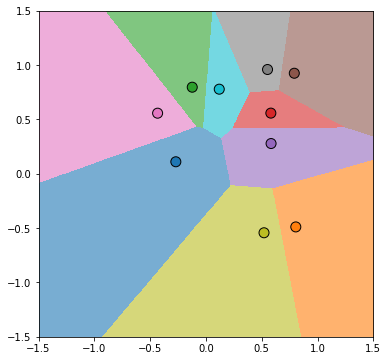

In [12]:
plt.figure(figsize=(6, 6))

cents = voronoi.dt.centers.data.cpu()
cent_label = np.arange(0, regions, step=1)

plt.scatter(*cents.t(), c=cent_label, s=100, cmap='tab10', ec='k')
    
# plt.gca().set_prop_cycle(None)
plt.imshow(cls.data.cpu().numpy().reshape(X1.shape), interpolation='nearest',
           extent=(-1.5, 1.5, -1.5, 1.5),
           alpha=0.6, cmap='tab10',
           aspect='auto', origin='lower')

In [13]:
cls

tensor([0, 0, 0,  ..., 5, 5, 5])

In [14]:
voronoi.dt.centers

Parameter containing:
tensor([[-0.2701,  0.1099],
        [ 0.8048, -0.4893],
        [-0.1230,  0.7958],
        [ 0.5813,  0.5574],
        [ 0.5833,  0.2777],
        [ 0.7914,  0.9242],
        [-0.4334,  0.5568],
        [ 0.5516,  0.9586],
        [ 0.5201, -0.5431],
        [ 0.1190,  0.7776]], requires_grad=True)

#### With output scale/bias

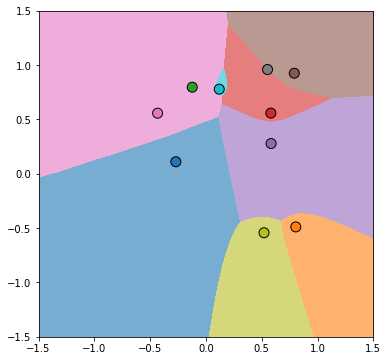

In [15]:
regions = 10
# voronoi = DistanceVoronoi(regions, bias=True)
voronoi._init_bias_()
cls = voronoi(XX)

cents = voronoi.dt.centers.data.cpu()
cent_label = np.arange(0, regions, step=1)

plt.figure(figsize=(6, 6))
plt.scatter(*cents.t(), c=cent_label, s=100, cmap='tab10', ec='k')
# plt.gca().set_prop_cycle(None)
plt.imshow(cls.data.cpu().numpy().reshape(X1.shape), interpolation='nearest',
           extent=(-1.5, 1.5, -1.5, 1.5),
           alpha=0.6, cmap='tab10',
           aspect='auto', origin='lower')

#### With weights shift

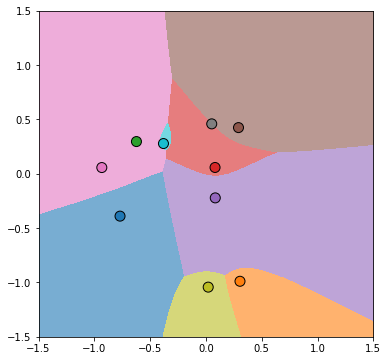

In [16]:
regions = 10
voronoi.dt.centers.data -= 0.5
cls = voronoi(XX)

cents = voronoi.dt.centers.data.cpu()
cent_label = np.arange(0, regions, step=1)

plt.figure(figsize=(6, 6))
plt.scatter(*cents.t(), c=cent_label, s=100, cmap='tab10', ec='k')
# plt.gca().set_prop_cycle(None)
plt.imshow(cls.data.cpu().numpy().reshape(X1.shape), interpolation='nearest',
           extent=(-1.5, 1.5, -1.5, 1.5),
           alpha=0.6, cmap='tab10',
           aspect='auto', origin='lower')

## Linear Voronoi

In [17]:
class LinearVoronoi(nn.Module):
    
    def __init__(self, h, bias=False):
        super().__init__()
        self.lin = nn.Linear(2, h, bias=False)
        self.lin.weight.data = torch.rand(self.lin.weight.shape)*2-1
#         self.lin.weight.data /= torch.norm(self.lin.weight.data, dim=1, keepdim=True)
        self.bias = None
        if bias:
            self._init_bias_()
        
    def _init_bias_(self):
        self.bias = torch.randn(self.lin.weight.shape[0])*0.2
        
    def forward(self, x):
        dists = self.lin(x)
        if self.bias is not None:
            dists = dists + self.bias
#         class_probs = torch.argmax(dists, dim=1)
        return torch.argmax(dists, dim=1)

    def set_centroid(self, index, value):
        self.lin.weight[index] = torch.Tensor(value, dtype=self.lin.weight.dtype)
        pass

In [18]:
regions = 10
voronoi = LinearVoronoi(regions)
cls = voronoi(XX)

In [19]:
torch.unique(cls, return_counts=True)

(tensor([1, 2, 4, 6, 8]), tensor([104352, 336393, 361785, 160992,  36478]))

In [20]:
# plt.figure(figsize=(6, 6))
# cf = plt.contourf(X1, X2, cls.data.cpu().numpy().reshape(X1.shape),
#              alpha=1.0, antialiased=True, levels=regions+1, cmap='tab20')

# plt.scatter(*voronoi.lin.weight.data.cpu().t(), marker='+', color='gray', ec="white")

# ### plot vectors 

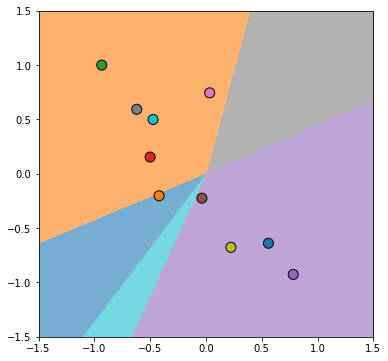

In [21]:
%matplotlib inline

plt.figure(figsize=(6, 6))

cls = voronoi(XX)
cents = voronoi.lin.weight.data.cpu()
cent_label = np.arange(0, regions, step=1)

plt.scatter(*cents.t(), c=cent_label, s=100, cmap='tab10', ec='k')
    
plt.gca().set_prop_cycle(None)
plt.imshow(cls.data.cpu().numpy().reshape(X1.shape), interpolation='nearest',
           extent=(-1.5, 1.5, -1.5, 1.5),
           alpha=0.6, cmap='tab10',
           aspect='auto', origin='lower')

In [22]:
voronoi.lin.weight.data

tensor([[ 0.5595, -0.6397],
        [-0.4201, -0.2026],
        [-0.9336,  0.9990],
        [-0.5005,  0.1535],
        [ 0.7819, -0.9265],
        [-0.0363, -0.2251],
        [ 0.0332,  0.7439],
        [-0.6200,  0.5929],
        [ 0.2231, -0.6772],
        [-0.4743,  0.4989]])

#### With output scale/bias

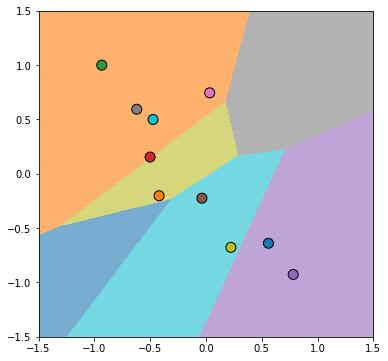

In [23]:
regions = 10
# voronoi = LinearVoronoi(regions, bias=True)
voronoi._init_bias_()
cls = voronoi(XX)

cents = voronoi.lin.weight.data.cpu()
cent_label = np.arange(0, regions, step=1)

plt.figure(figsize=(6, 6))
plt.scatter(*cents.t(), c=cent_label, s=100, cmap='tab10', ec='k')
    
plt.gca().set_prop_cycle(None)
plt.imshow(cls.data.cpu().numpy().reshape(X1.shape), interpolation='nearest',
           extent=(-1.5, 1.5, -1.5, 1.5),
           alpha=0.6, cmap='tab10',
           aspect='auto', origin='lower')

#### With weights shift

In [24]:
voronoi.lin.weight.data -= 0.5

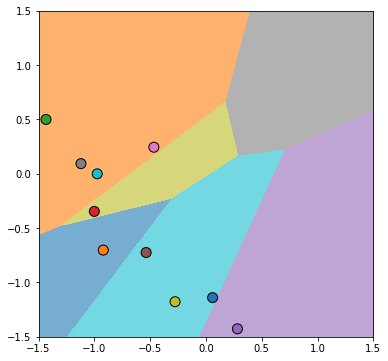

In [25]:
plt.figure(figsize=(6, 6))

cls = voronoi(XX)
cents = voronoi.lin.weight.data.cpu()
cent_label = np.arange(0, regions, step=1)

plt.scatter(*cents.t(), c=cent_label, s=100, cmap='tab10', ec='k')
    
plt.gca().set_prop_cycle(None)
plt.imshow(cls.data.cpu().numpy().reshape(X1.shape), interpolation='nearest',
           extent=(-1.5, 1.5, -1.5, 1.5),
           alpha=0.6, cmap='tab10',
           aspect='auto', origin='lower')